# Download Uncommon libraries

In [2]:
!pip install bayesian-optimization
!pip install --upgrade lightgbm

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_squared_error, r2_score,
                             precision_score, recall_score, f1_score, confusion_matrix)
import seaborn as sns
import os


# Custom Encoding Mappings

In [4]:
# Indian-specific constants
USD_TO_INR = 83.0  # Current conversion rate
PPP_ADJUSTMENT_FACTOR = 0.22  # Purchasing Power Parity ratio

# Indian expense category adjustments (PPP-based)
INDIAN_EXPENSE_ADJUSTMENTS = {
    'Rent': 0.5,
    'Loan_Repayment': 1.0,
    'Insurance': 0.7,
    'Groceries': 1.8,
    'Transport': 0.7,
    'Eating_Out': 1.3,
    'Entertainment': 1.2,
    'Utilities': 0.6,
    'Healthcare': 0.6,
    'Education': 0.4,
    'Miscellaneous': 1.0
}

occupation_mapping = {
    'Retired': 0,
    'Student': 1,
    'Self_Employed': 2,
    'Professional': 3,
    'Homemaker': 4
}

city_tier_mapping = {
    'Tier_1': 0,
    'Tier_2': 1,
    'Tier_3': 2
}

# Data Loading & Preprocessing

In [13]:
def convert_to_indian_rupees(df):
    """Convert dollar amounts to rupees with PPP adjustments"""
    expense_cols = ['Income', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries',
                   'Transport', 'Eating_Out', 'Entertainment', 'Utilities',
                   'Healthcare', 'Education', 'Miscellaneous', 'Desired_Savings',
                   'Potential_Savings_Groceries', 'Potential_Savings_Transport',
                   'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment',
                   'Potential_Savings_Utilities', 'Potential_Savings_Healthcare',
                   'Potential_Savings_Education', 'Potential_Savings_Miscellaneous']

    for col in expense_cols:
        if col in df.columns:
            df[col] = df[col] * USD_TO_INR
            base_col = col.replace('Potential_Savings_', '')
            if base_col in INDIAN_EXPENSE_ADJUSTMENTS:
                df[col] = df[col] * INDIAN_EXPENSE_ADJUSTMENTS[base_col]

    return df

def load_and_preprocess(filepath):
    """Load and preprocess data with Indian financial context"""
    df = pd.read_csv(filepath)

    df = convert_to_indian_rupees(df)

    # Map categorical variables
    df['Occupation'] = df['Occupation'].map(occupation_mapping)
    df['City_Tier'] = df['City_Tier'].map(city_tier_mapping)

    # Calculate expense percentages
    expense_cols = ['Rent', 'Loan_Repayment', 'Insurance', 'Groceries',
                   'Transport', 'Eating_Out', 'Entertainment', 'Utilities',
                   'Healthcare', 'Education', 'Miscellaneous']

    for col in expense_cols:
        df[f'{col}_Pct'] = df[col] / df['Income']

    # Calculate savings target - ensure it doesn't exceed income
    df['Savings_Target'] = np.where(
        df['Desired_Savings_Percentage'].notnull(),
        df['Income'] * df['Desired_Savings_Percentage'].clip(upper=1.0),  # Cap at 100%
        df['Desired_Savings'].clip(upper=df['Income'])  # Cap at income level
    )

    # Instead of raising error, cap the savings target
    df['Savings_Target'] = df['Savings_Target'].clip(upper=df['Income'])

    return df


In [15]:
class FinancialOptimizer:
    def __init__(self):
        self.models = {}
        self.feature_cols = [
            'Income', 'Age', 'Dependents', 'Occupation', 'City_Tier',
            'Rent_Pct', 'Loan_Repayment_Pct', 'Insurance_Pct', 'Groceries_Pct',
            'Transport_Pct', 'Eating_Out_Pct', 'Entertainment_Pct',
            'Utilities_Pct', 'Healthcare_Pct', 'Education_Pct',
            'Miscellaneous_Pct', 'Savings_Target'
        ]

        self.target_cols = [
            'Potential_Savings_Groceries', 'Potential_Savings_Transport',
            'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment',
            'Potential_Savings_Utilities', 'Potential_Savings_Healthcare',
            'Potential_Savings_Education', 'Potential_Savings_Miscellaneous'
        ]

    def train(self, df):
        """Train models with Indian financial context"""
        X = df[self.feature_cols]
        y = df[self.target_cols]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Indian-specific hyperparameter ranges
        best_params = self._bayesian_optimization(X_train, y_train, X_test, y_test)

        for target in self.target_cols:
            print(f"\nTraining model for {target.replace('Potential_Savings_', '')}...")
            train_data = lgb.Dataset(X_train, y_train[target])
            self.models[target] = lgb.train(
                {**best_params, 'objective': 'regression', 'metric': 'mae'},
                train_data,
                valid_sets=[lgb.Dataset(X_test, y_test[target])],
                callbacks=[log_evaluation(100), early_stopping(20)],
            )

        self._evaluate_models(X_test, y_test)

    def _bayesian_optimization(self, X_train, y_train, X_test, y_test):
        """Optimize with Indian financial patterns in mind"""
        def lgb_eval(num_leaves, max_depth, learning_rate, lambda_l2):
            params = {
                'objective': 'regression',
                'metric': 'mae',
                'num_leaves': int(num_leaves),
                'max_depth': int(max_depth),
                'learning_rate': learning_rate,
                'lambda_l2': lambda_l2,
                'verbosity': -1
            }

            avg_mae = 0
            for target in self.target_cols:
                train_data = lgb.Dataset(X_train, y_train[target])
                model = lgb.train(params, train_data,
                                valid_sets=[lgb.Dataset(X_test, y_test[target])],
                                callbacks=[log_evaluation(100), early_stopping(20)])
                avg_mae += model.best_score['valid_0']['l1']

            return -avg_mae/len(self.target_cols)

        optimizer = BayesianOptimization(
            f=lgb_eval,
            pbounds={
                'num_leaves': (20, 100),
                'max_depth': (3, 15),
                'learning_rate': (0.01, 0.3),
                'lambda_l2': (0, 5)
            },
            random_state=42
        )
        optimizer.maximize(init_points=5, n_iter=20)  # Reduced for faster iteration

        best_params = optimizer.max['params']
        return {
            'num_leaves': int(best_params['num_leaves']),
            'max_depth': int(best_params['max_depth']),
            'learning_rate': best_params['learning_rate'],
            'lambda_l2': best_params['lambda_l2']
        }

    def _evaluate_models(self, X_test, y_test):
        """Evaluate with Indian rupee values"""
        print("\nModel Evaluation (values in ₹):")
        results = {}
        for target in self.target_cols:
            preds = self.models[target].predict(X_test)
            mae = mean_absolute_error(y_test[target], preds)
            results[target] = mae
            print(f"{target.replace('Potential_Savings_', ''):<20}: MAE = ₹{mae:,.2f}")

    def explain(self, X_sample):
        """Explain with Indian rupee values"""
        explainer = shap.TreeExplainer(self.models[self.target_cols[0]])
        shap_values = explainer.shap_values(X_sample)

        plt.figure(figsize=(12,6))
        shap.summary_plot(shap_values, X_sample, plot_type='bar', feature_names=self.feature_cols)
        plt.title("Feature Importance for Savings Recommendations (₹)")
        plt.show()

    def predict(self, input_data):
        """Predict with Indian financial context"""
        self._validate_input(input_data)

        input_df = pd.DataFrame([input_data])

        input_df = convert_to_indian_rupees(input_df)

        input_df['Occupation'] = occupation_mapping[input_data['Occupation']]
        input_df['City_Tier'] = city_tier_mapping[input_data['City_Tier']]

        expense_cols = [col for col in input_data if col in [
            'Rent', 'Loan_Repayment', 'Insurance', 'Groceries',
            'Transport', 'Eating_Out', 'Entertainment', 'Utilities',
            'Healthcare', 'Education', 'Miscellaneous'
        ]]

        for col in expense_cols:
            input_df[f'{col}_Pct'] = input_data[col] / input_data['Income']

        input_df['Savings_Target'] = (
            input_data['Income'] * input_data['Desired_Savings_Percentage']
            if input_data['Desired_Savings_Percentage'] is not None
            else input_data['Desired_Savings']
        )

        recommendations = {}
        for target in self.target_cols:
            expense_type = '_'.join(target.split('_')[2:])
            current_spending = input_data[expense_type]
            predicted_saving = self.models[target].predict(input_df[self.feature_cols])[0]

            safe_saving = min(predicted_saving, current_spending)
            recommendations[expense_type] = {
                'current_spending': current_spending,
                'recommended_saving': safe_saving,
                'saving_percentage': (safe_saving / current_spending) * 100 if current_spending != 0 else 0
            }

        return recommendations

    def _validate_input(self, input_data):
        """Indian-specific input validation"""
        required_keys = ['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier',
                        'Desired_Savings_Percentage', 'Desired_Savings']

        missing = set(required_keys) - set(input_data.keys())
        if missing:
            raise ValueError(f"Missing required fields: {missing}")

        if input_data['Income'] <= 0:
            raise ValueError("Income must be positive")
        if input_data['Income'] > 50000000:
            raise ValueError("Income exceeds realistic Indian ranges")

        if input_data['Occupation'] not in occupation_mapping:
            raise ValueError(f"Invalid Occupation. Must be one of: {list(occupation_mapping.keys())}")

        if input_data['City_Tier'] not in city_tier_mapping:
            raise ValueError(f"Invalid City_Tier. Must be one of: {list(city_tier_mapping.keys())}")

        if (input_data['Desired_Savings_Percentage'] is None and
            input_data['Desired_Savings'] is None):
            raise ValueError("Must provide either Desired_Savings_Percentage or Desired_Savings")

    def evaluate(self, X_test, y_test):
        """Enhanced evaluation with Indian context"""
        results = {}

        for target in self.target_cols:
            preds = self.models[target].predict(X_test)
            actual = y_test[target]

            preds_lakhs = preds / 100000
            actual_lakhs = actual / 100000

            mae = mean_absolute_error(actual_lakhs, preds_lakhs)
            mse = mean_squared_error(actual_lakhs, preds_lakhs)
            r2 = r2_score(actual_lakhs, preds_lakhs)

            bins = np.quantile(actual_lakhs, [0, 0.33, 0.66, 1])
            actual_binned = np.digitize(actual_lakhs, bins)
            preds_binned = np.digitize(preds_lakhs, bins)

            precision = precision_score(actual_binned, preds_binned, average='weighted')
            recall = recall_score(actual_binned, preds_binned, average='weighted')
            f1 = f1_score(actual_binned, preds_binned, average='weighted')

            results[target] = {
                'MAE (₹ lakhs)': mae,
                'MSE (₹ lakhs)': mse,
                'R²': r2,
                'Precision': precision,
                'Recall': recall,
                'F1': f1
            }

            self._plot_regression_diagnostics(actual_lakhs, preds_lakhs, target)
            self._plot_confusion_matrix(actual_binned, preds_binned, target)

        return results

    def _plot_regression_diagnostics(self, actual, preds, target_name):
        """Plot diagnostics with Indian rupee values"""
        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.scatter(actual, preds, alpha=0.3)
        plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
        plt.title(f'{target_name.replace("Potential_Savings_", "")}\nActual vs Predicted (₹ lakhs)')
        plt.xlabel('Actual Values (₹ lakhs)')
        plt.ylabel('Predictions (₹ lakhs)')

        plt.subplot(1, 3, 2)
        residuals = preds - actual
        sns.histplot(residuals, kde=True, bins=30)
        plt.title('Residual Distribution (₹ lakhs)')
        plt.xlabel('Prediction Errors (₹ lakhs)')

        plt.subplot(1, 3, 3)
        nonzero_mask = actual != 0
        error_pct = np.zeros_like(actual)
        error_pct[nonzero_mask] = (residuals[nonzero_mask]/actual[nonzero_mask])*100
        sns.boxplot(x=error_pct)
        plt.title('Percentage Error Distribution')
        plt.xlabel('% Error')

        plt.tight_layout()
        plt.show()

    def _plot_confusion_matrix(self, actual_binned, preds_binned, target_name):
        """Generate confusion matrix with Indian context"""
        labels = ['Low', 'Medium', 'High']
        cm = confusion_matrix(actual_binned, preds_binned)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{target_name.replace("Potential_Savings_", "")}\nSavings Potential (₹ lakhs)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Main Execution

|   iter    |  target   | lambda_l2 | learni... | max_depth | num_le... |
-------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 49796.8
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 10218.7
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 10093.3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 8974.41
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 7786.45
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1044.89
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's l1:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


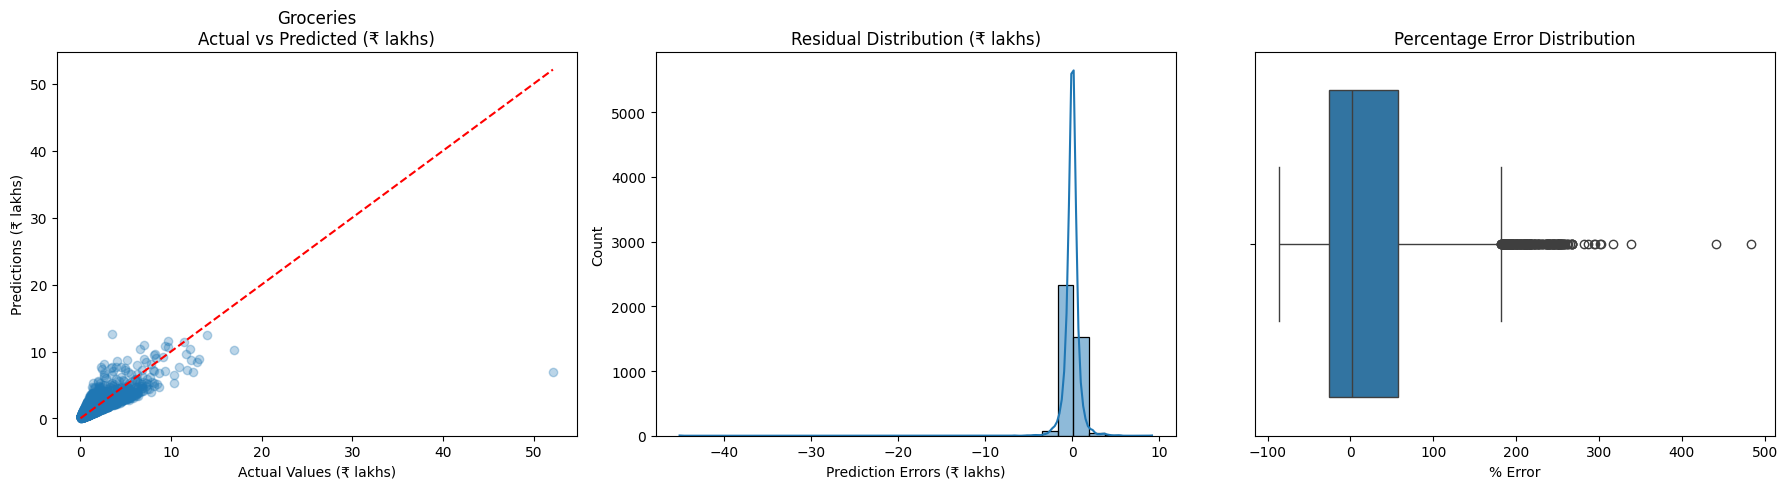

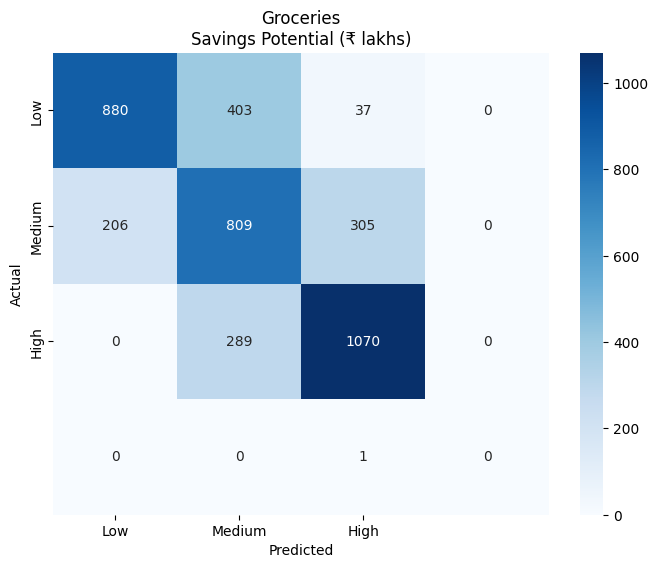

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


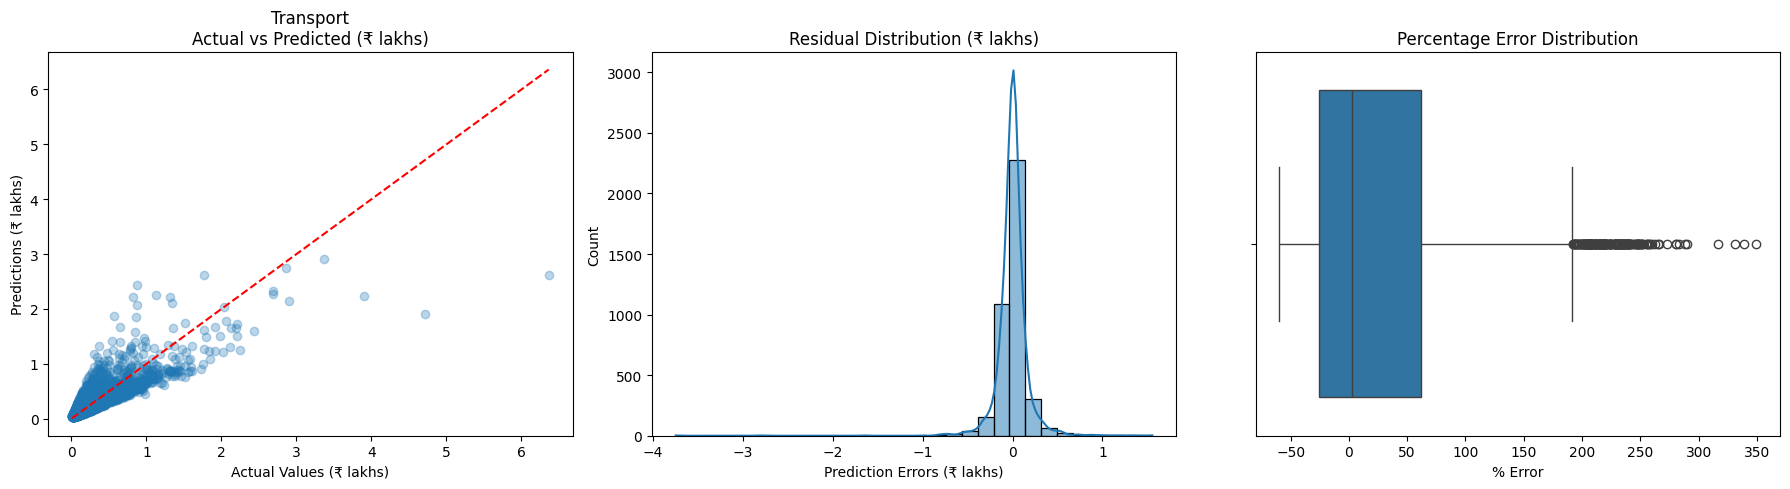

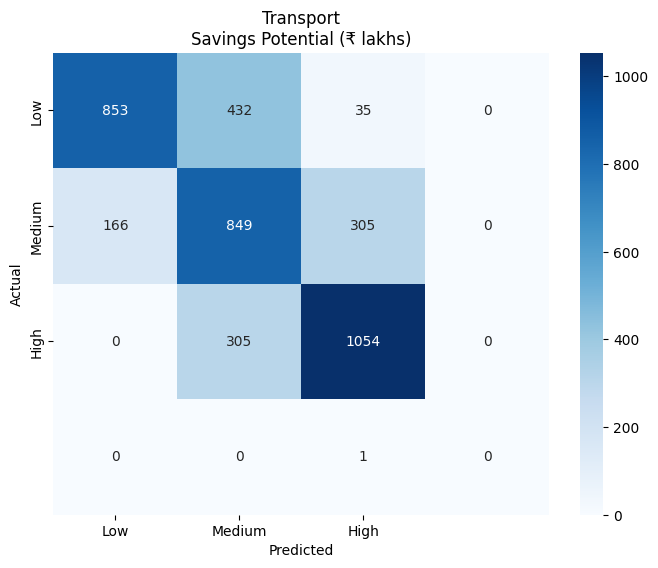

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


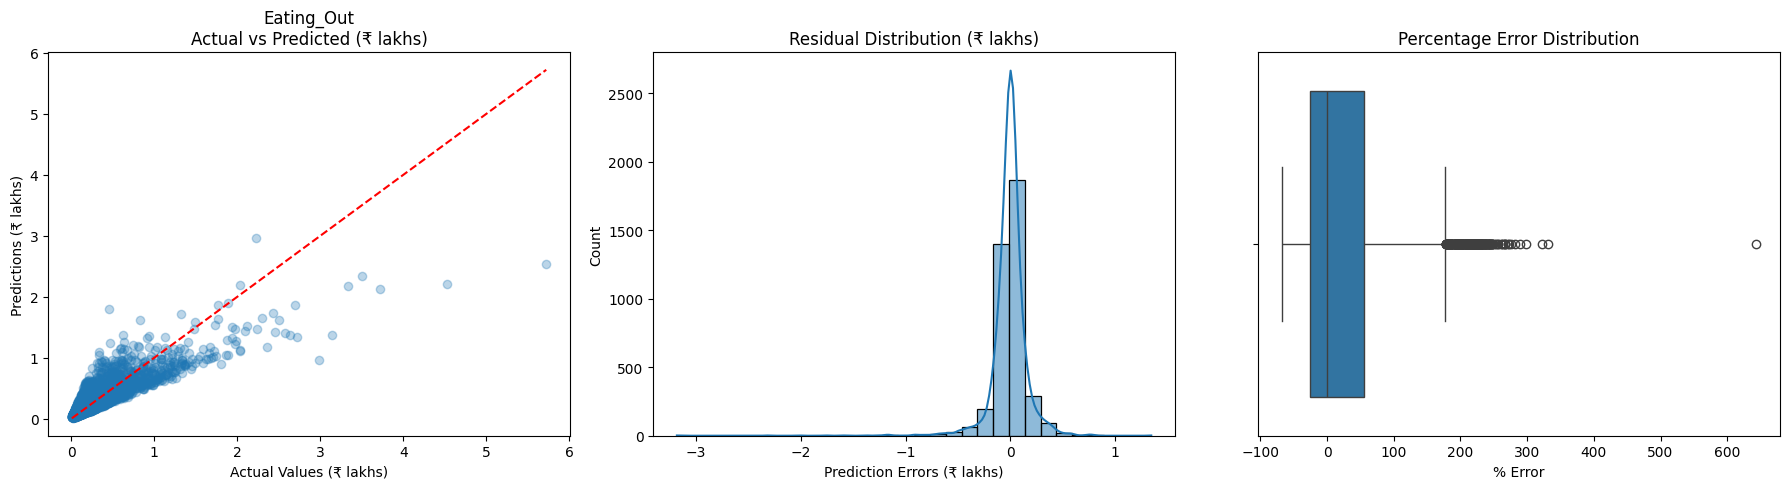

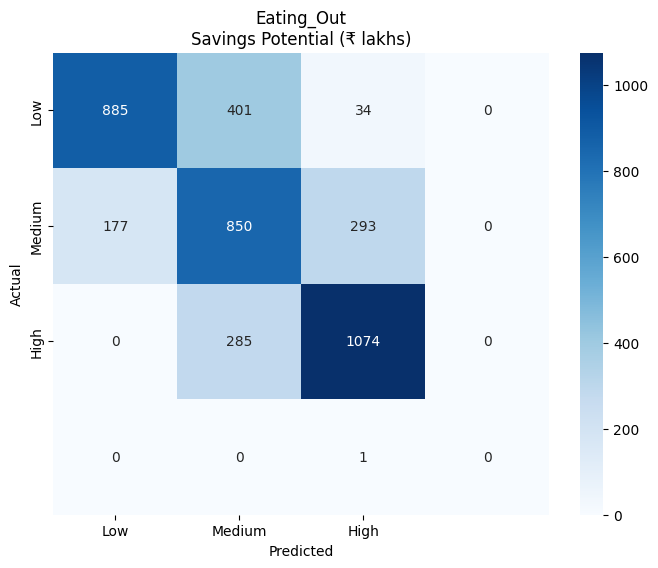

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


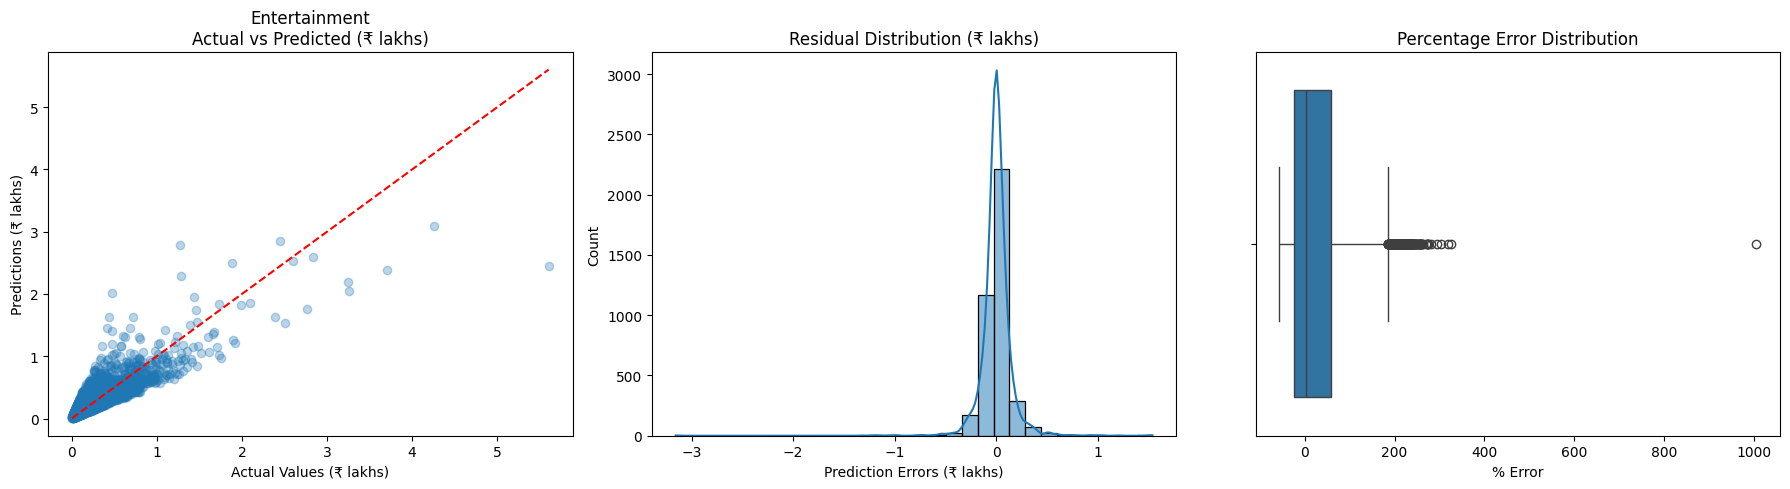

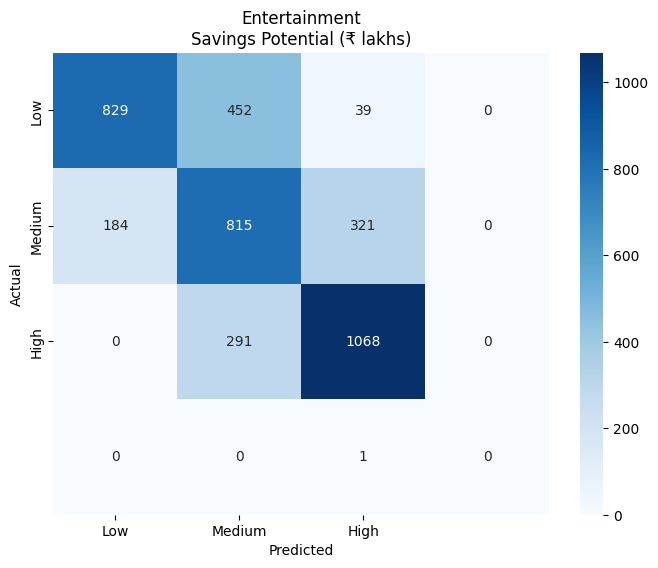

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


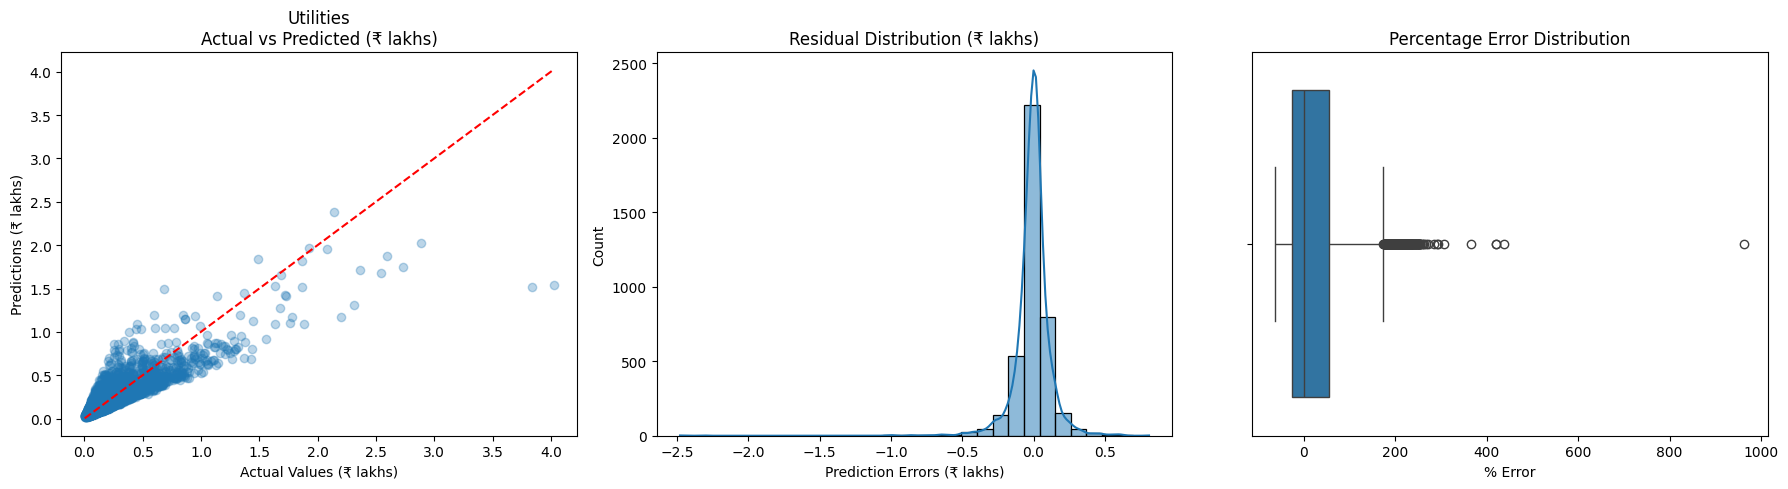

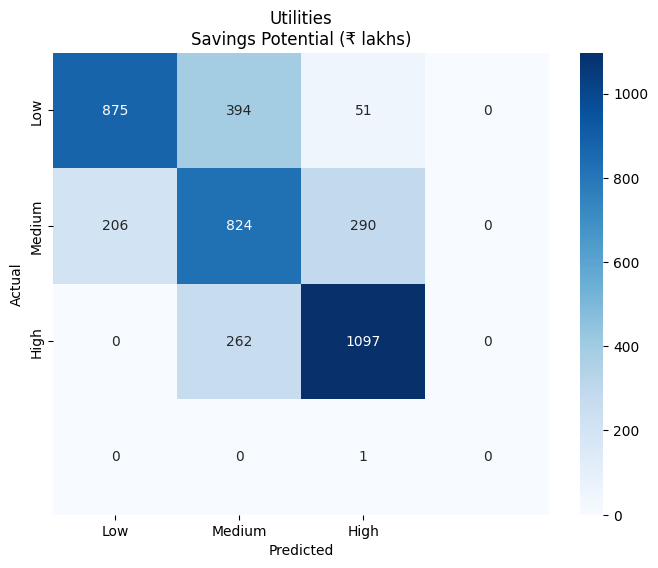

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


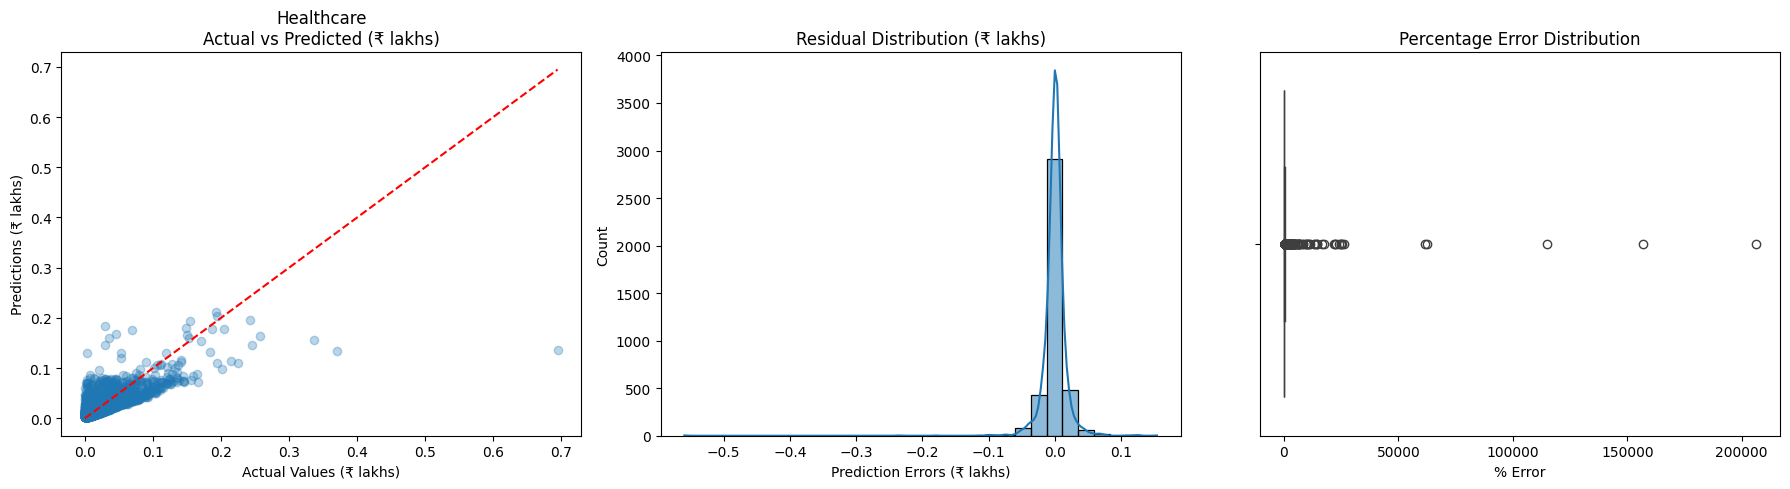

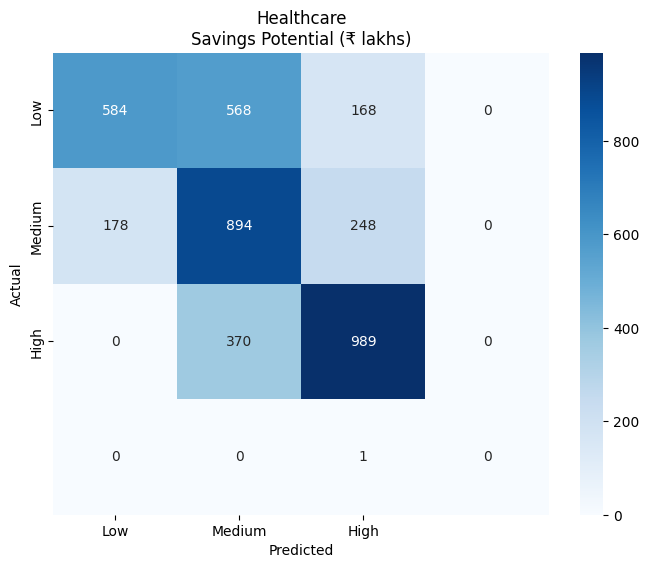

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


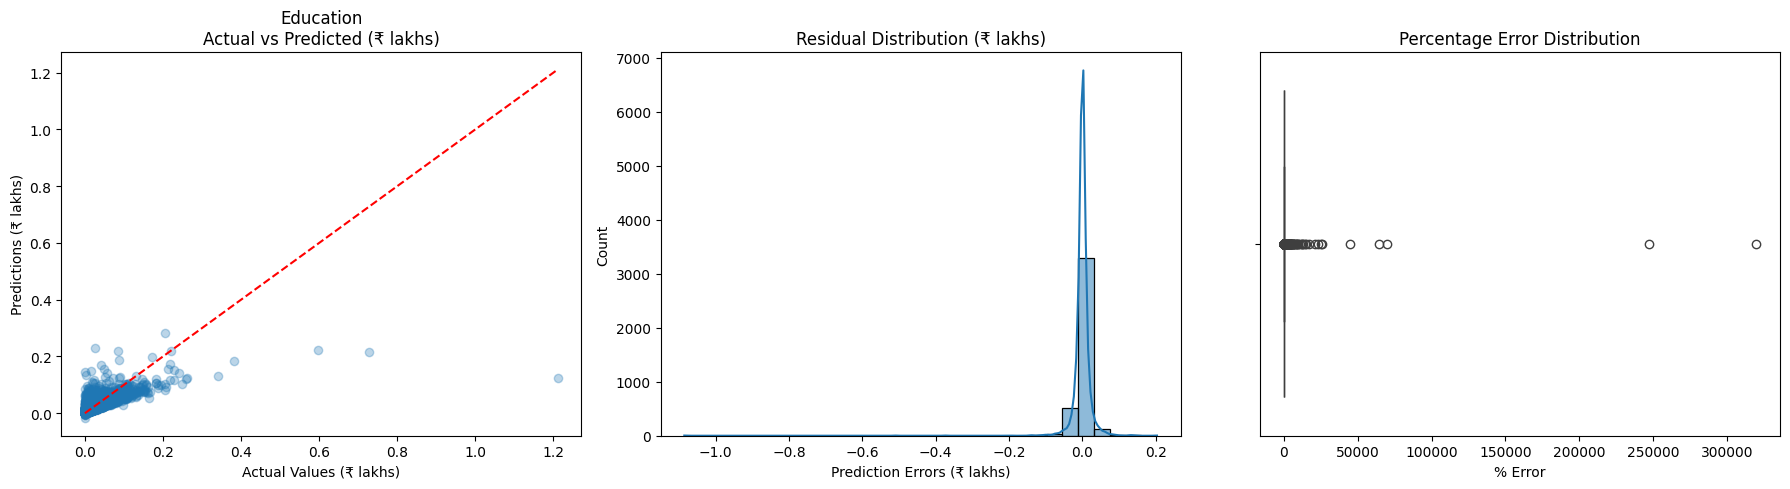

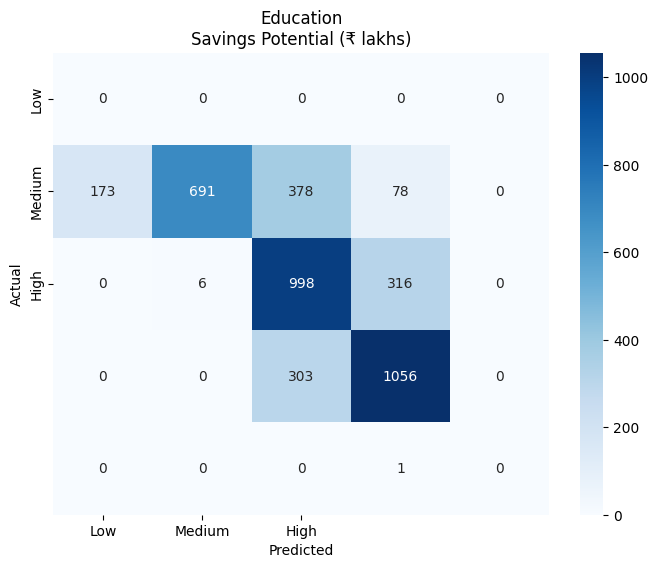

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


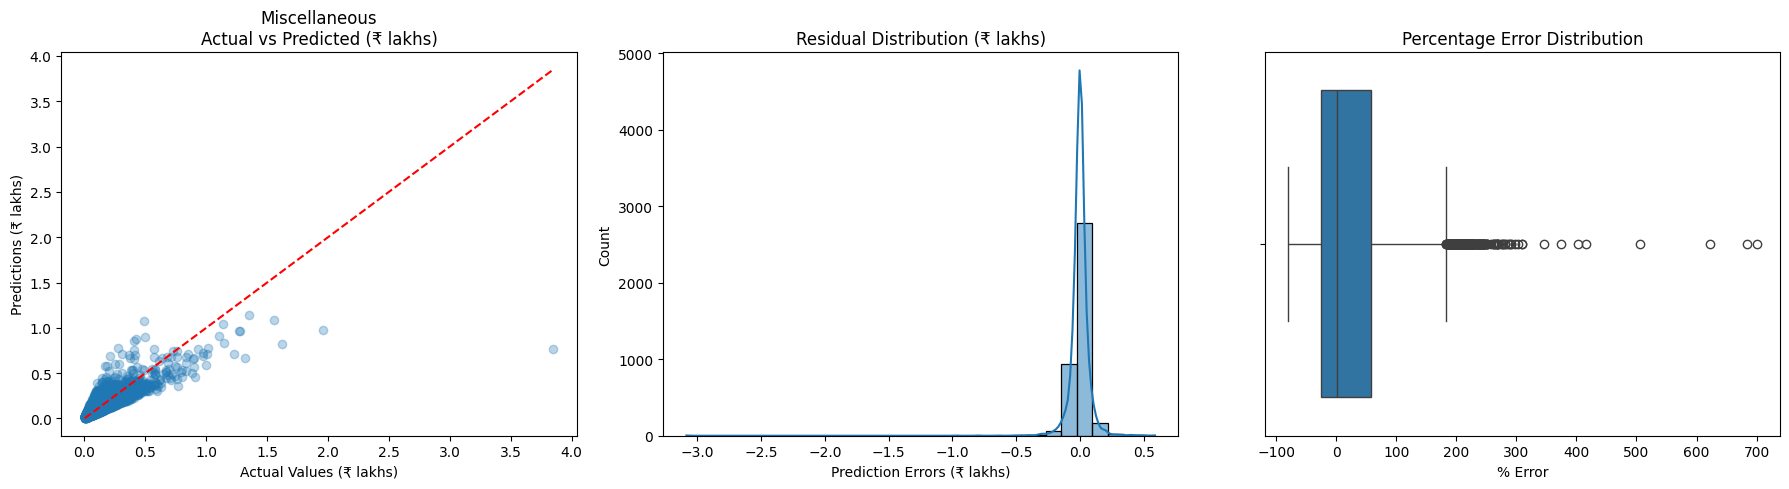

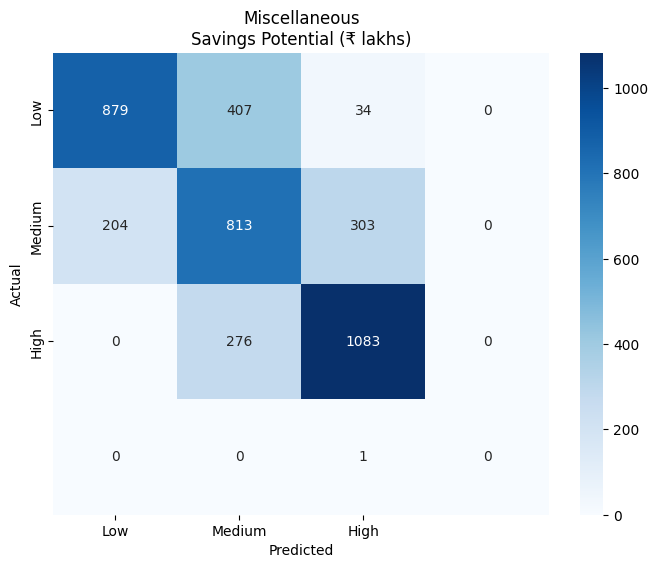


Model Performance Summary:

Groceries           :
  MAE: ₹0.49 lakhs
  MSE: ₹1.11 lakhs
  R²: 0.60
  Precision: 0.70
  Recall: 0.69
  F1 Score: 0.69

Transport           :
  MAE: ₹0.10 lakhs
  MSE: ₹0.03 lakhs
  R²: 0.69
  Precision: 0.71
  Recall: 0.69
  F1 Score: 0.69

Eating_Out          :
  MAE: ₹0.10 lakhs
  MSE: ₹0.03 lakhs
  R²: 0.73
  Precision: 0.72
  Recall: 0.70
  F1 Score: 0.71

Entertainment       :
  MAE: ₹0.09 lakhs
  MSE: ₹0.02 lakhs
  R²: 0.73
  Precision: 0.70
  Recall: 0.68
  F1 Score: 0.68

Utilities           :
  MAE: ₹0.08 lakhs
  MSE: ₹0.02 lakhs
  R²: 0.74
  Precision: 0.71
  Recall: 0.70
  F1 Score: 0.70

Healthcare          :
  MAE: ₹0.01 lakhs
  MSE: ₹0.00 lakhs
  R²: 0.56
  Precision: 0.65
  Recall: 0.62
  F1 Score: 0.62

Education           :
  MAE: ₹0.01 lakhs
  MSE: ₹0.00 lakhs
  R²: 0.47
  Precision: 0.77
  Recall: 0.69
  F1 Score: 0.70

Miscellaneous       :
  MAE: ₹0.04 lakhs
  MSE: ₹0.01 lakhs
  R²: 0.68
  Precision: 0.71
  Recall: 0.69
  F1 Score: 0

In [16]:
if __name__ == "__main__":

    df = load_and_preprocess('data.csv')


    optimizer = FinancialOptimizer()
    optimizer.train(df)


    sample_input = {
        'Income': 1500000,
        'Age': 35,
        'Dependents': 2,
        'Occupation': 'Professional',
        'City_Tier': 'Tier_2',
        'Rent': 360000,
        'Loan_Repayment': 180000,
        'Insurance': 60000,
        'Groceries': 240000,
        'Transport': 120000,
        'Eating_Out': 96000,
        'Entertainment': 60000,
        'Utilities': 72000,
        'Healthcare': 48000,
        'Education': 120000,
        'Miscellaneous': 60000,
        'Desired_Savings_Percentage': 0.25,
        'Desired_Savings': None
    }

    recommendations = optimizer.predict(sample_input)
    print("\nSavings Recommendations (₹):")
    for category, data in recommendations.items():
        print(f"\n{category}:")
        print(f"  Current: ₹{data['current_spending']:,.2f}")
        print(f"  Recommended Savings: ₹{data['recommended_saving']:,.2f}")
        print(f"  Savings Percentage: {data['saving_percentage']:.1f}%")


# Model evaluation

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


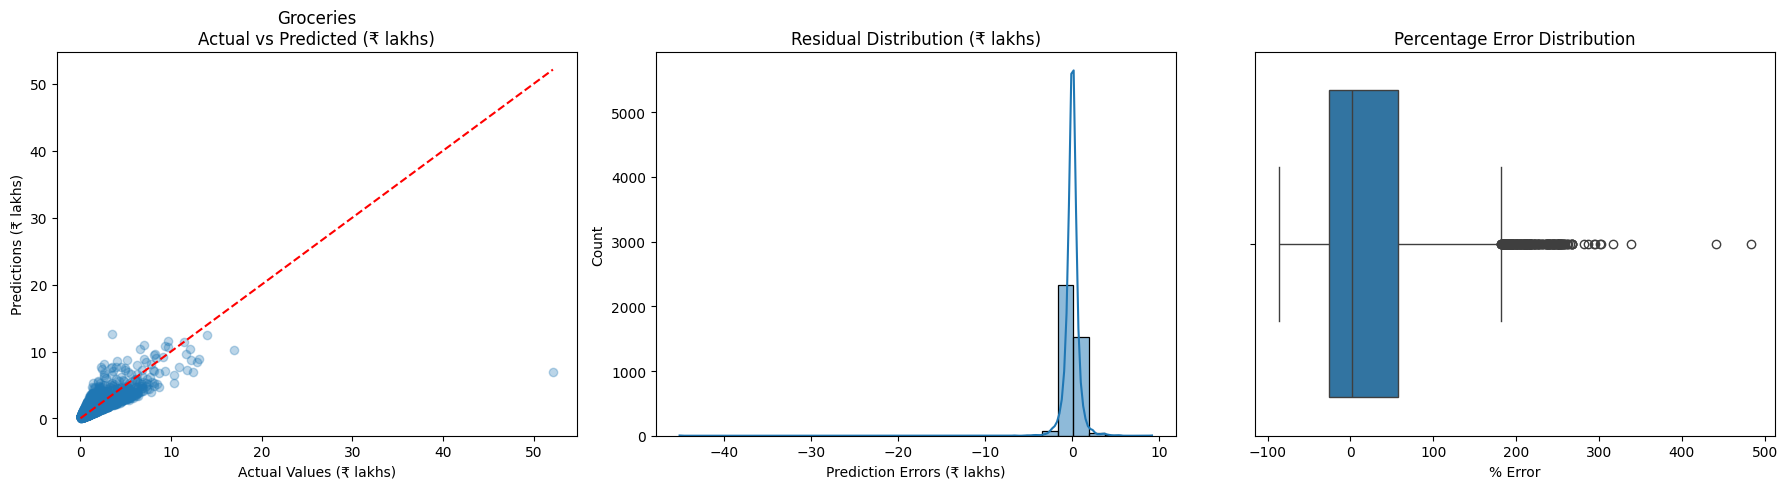

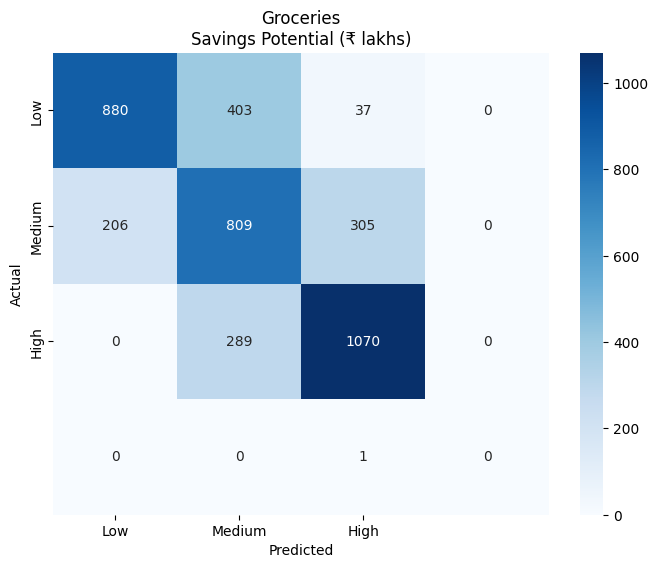

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


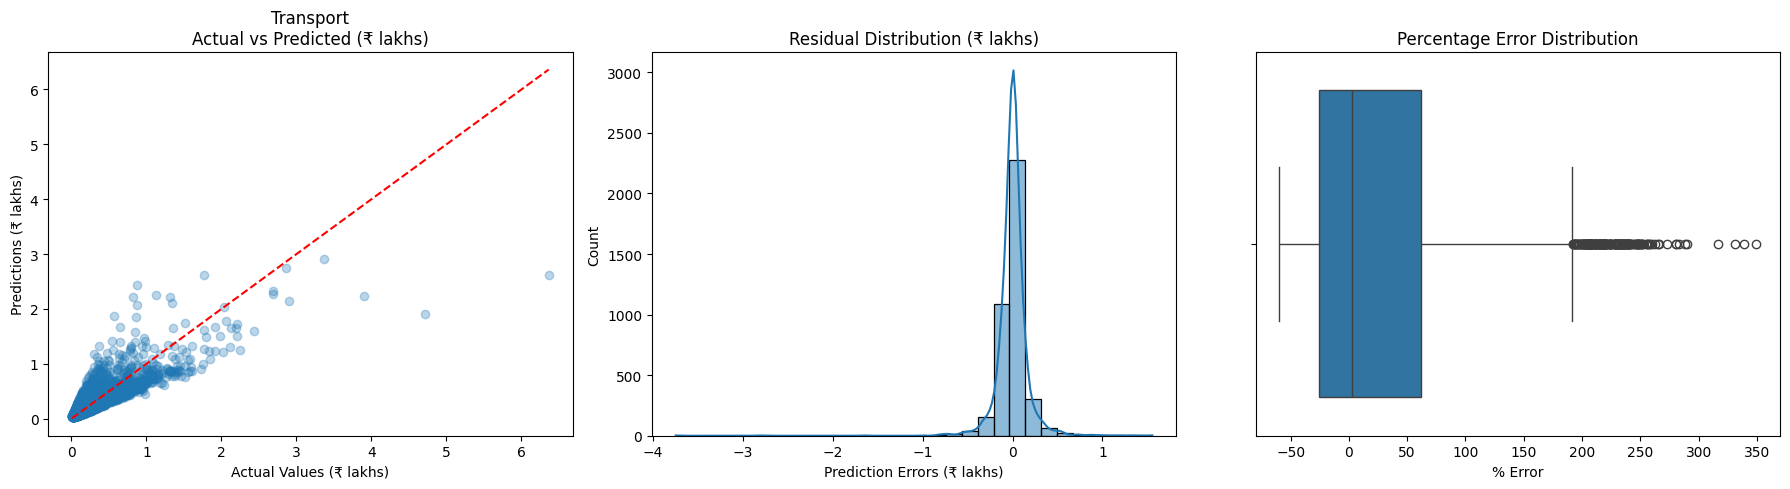

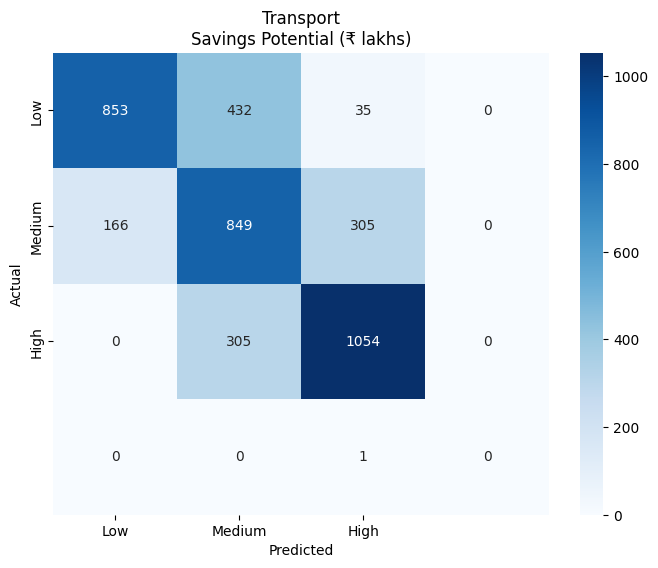

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


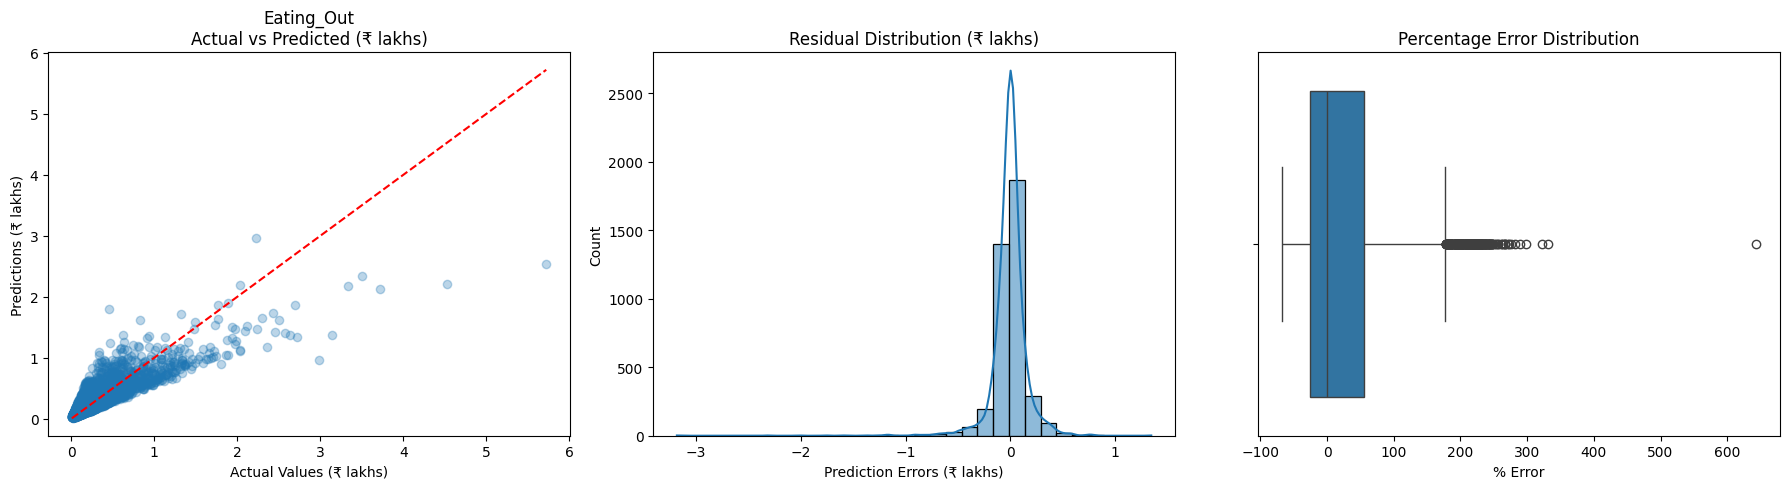

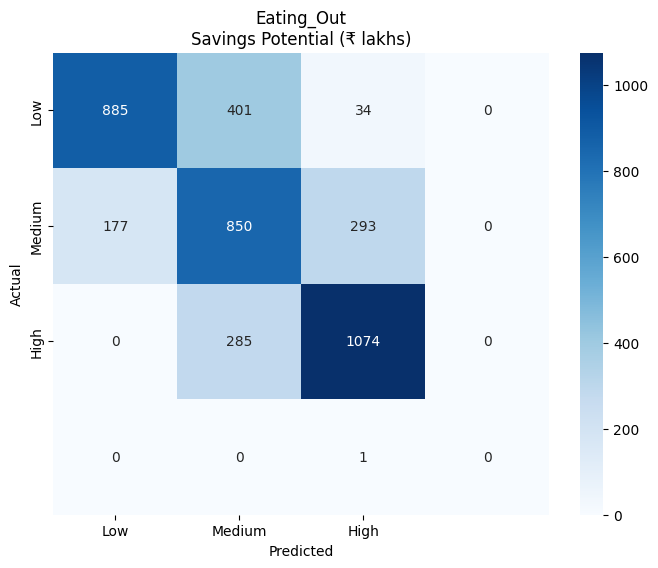

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


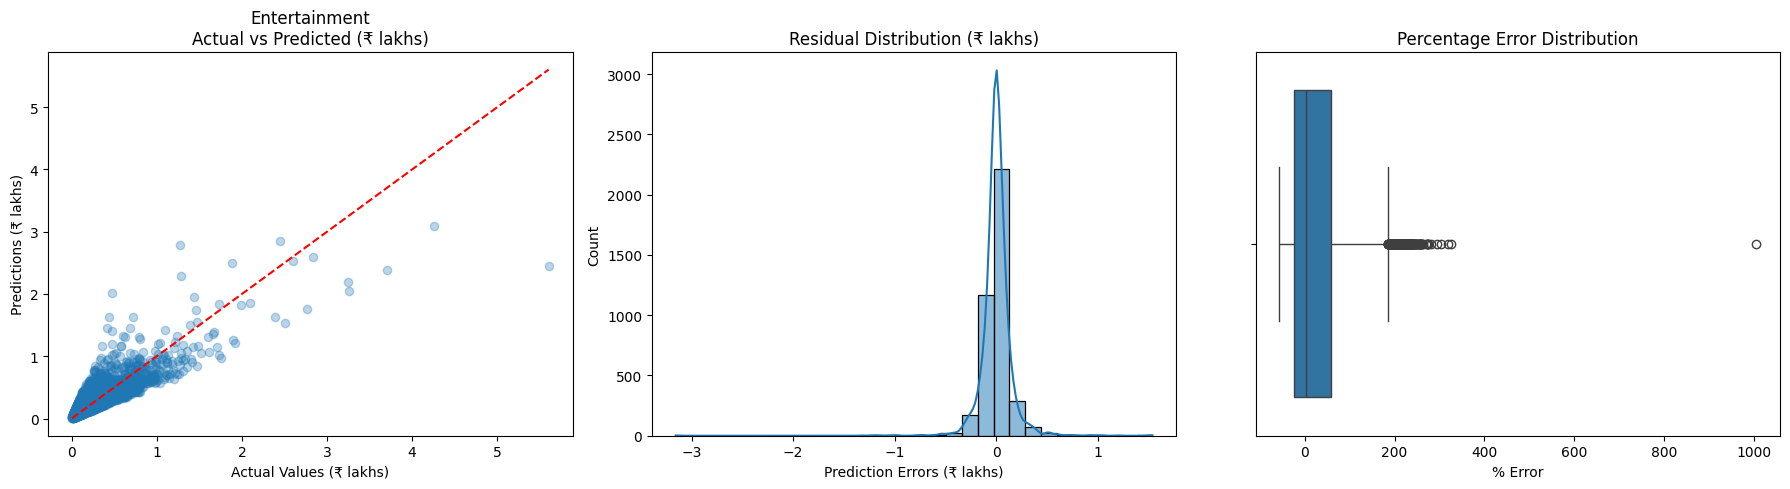

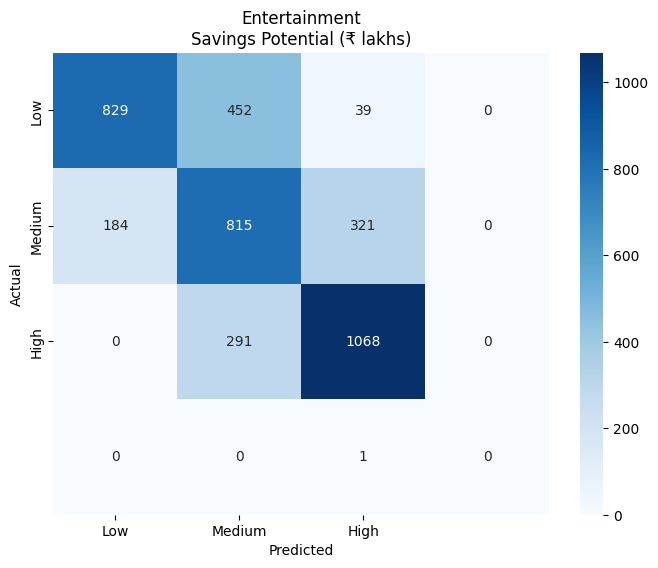

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


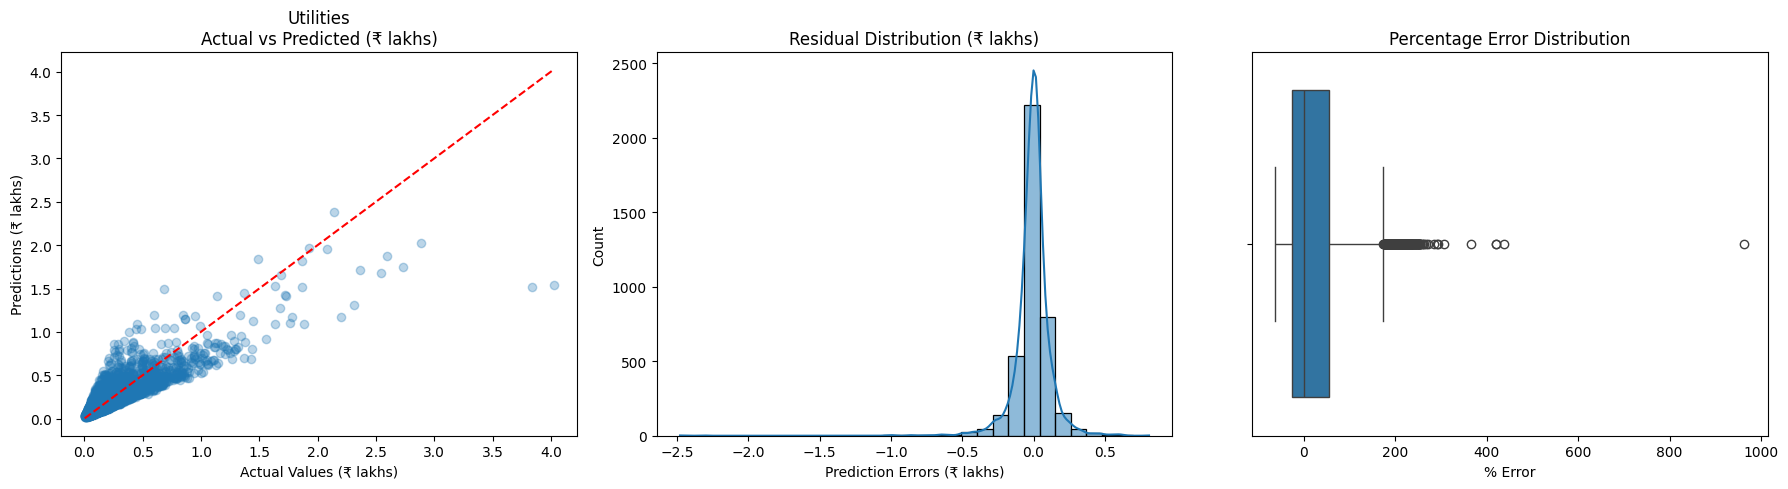

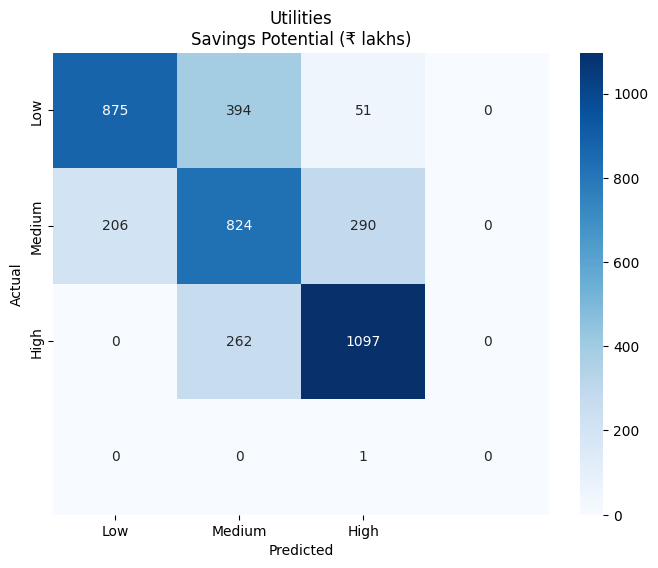

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


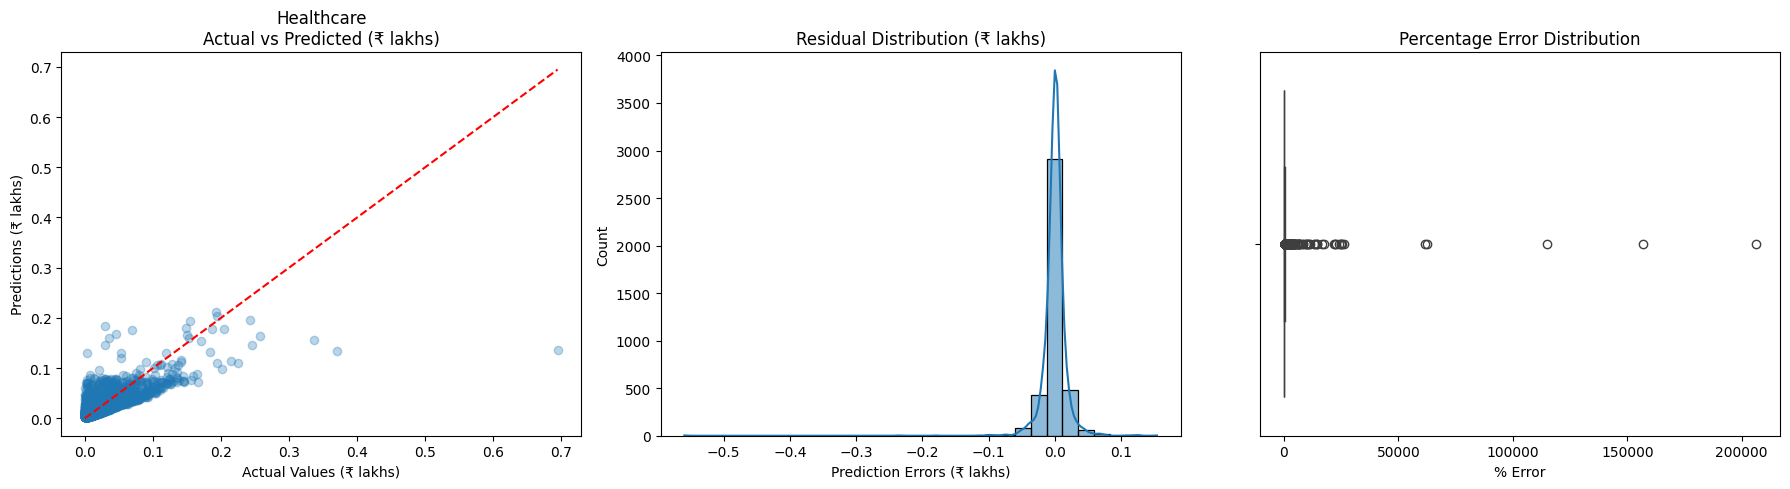

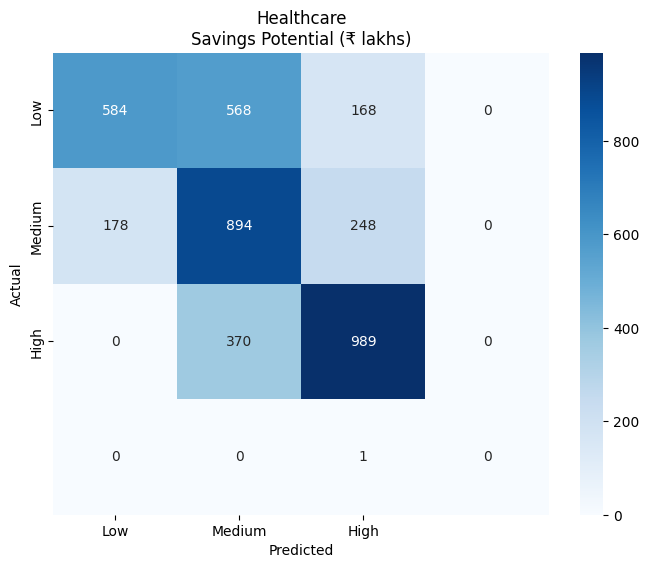

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


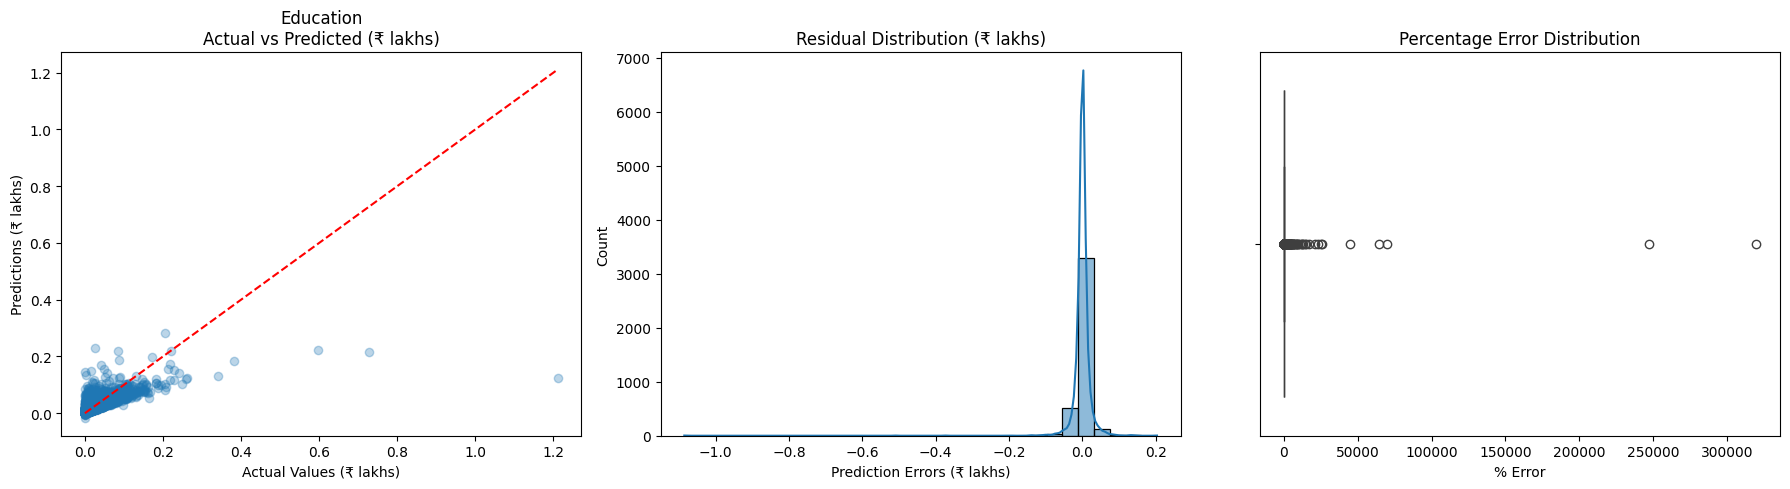

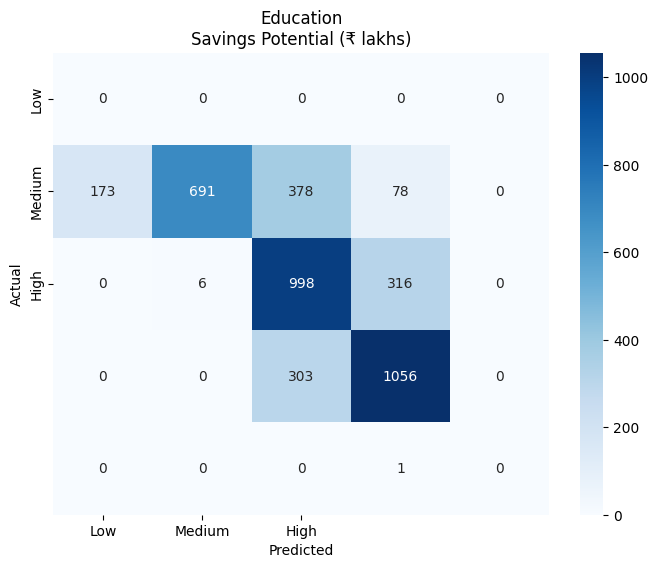

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


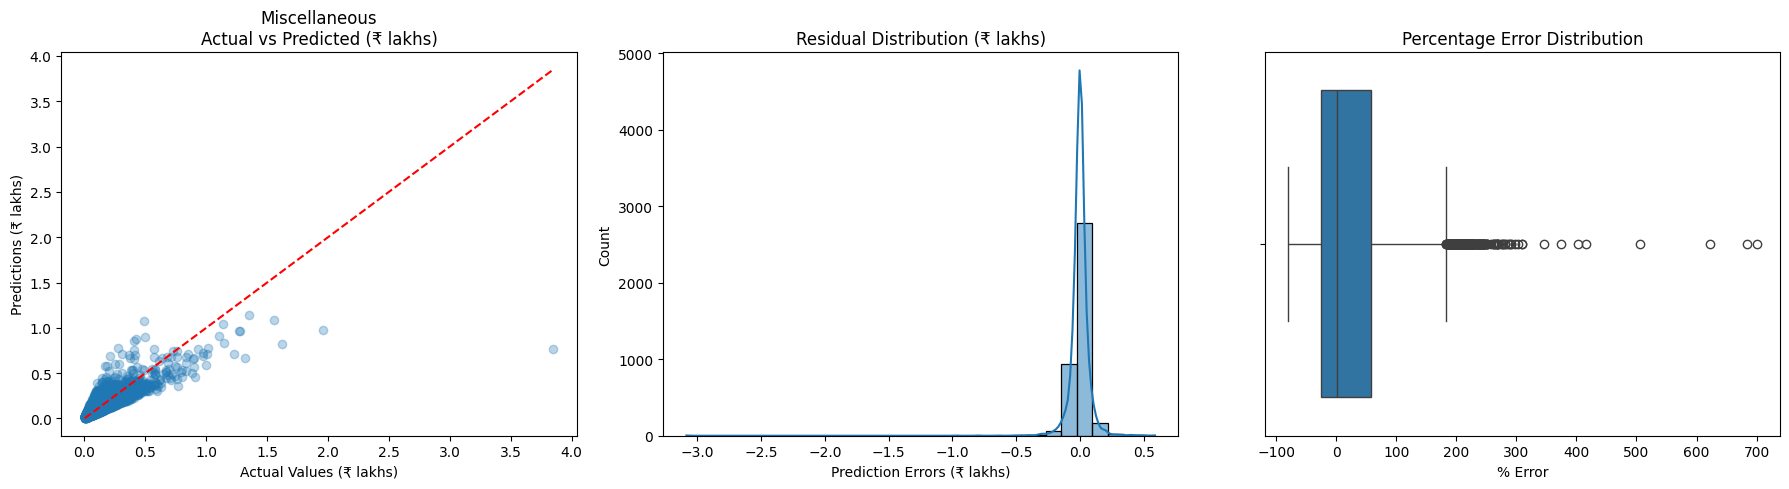

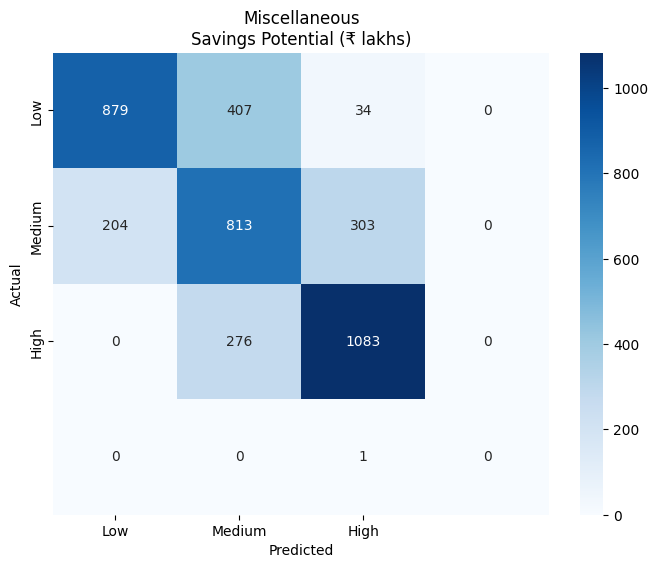


Model Performance Summary:

Groceries           :
  MAE: ₹0.49 lakhs
  MSE: ₹1.11 lakhs
  R²: 0.60
  Precision: 0.70
  Recall: 0.69
  F1 Score: 0.69

Transport           :
  MAE: ₹0.10 lakhs
  MSE: ₹0.03 lakhs
  R²: 0.69
  Precision: 0.71
  Recall: 0.69
  F1 Score: 0.69

Eating_Out          :
  MAE: ₹0.10 lakhs
  MSE: ₹0.03 lakhs
  R²: 0.73
  Precision: 0.72
  Recall: 0.70
  F1 Score: 0.71

Entertainment       :
  MAE: ₹0.09 lakhs
  MSE: ₹0.02 lakhs
  R²: 0.73
  Precision: 0.70
  Recall: 0.68
  F1 Score: 0.68

Utilities           :
  MAE: ₹0.08 lakhs
  MSE: ₹0.02 lakhs
  R²: 0.74
  Precision: 0.71
  Recall: 0.70
  F1 Score: 0.70

Healthcare          :
  MAE: ₹0.01 lakhs
  MSE: ₹0.00 lakhs
  R²: 0.56
  Precision: 0.65
  Recall: 0.62
  F1 Score: 0.62

Education           :
  MAE: ₹0.01 lakhs
  MSE: ₹0.00 lakhs
  R²: 0.47
  Precision: 0.77
  Recall: 0.69
  F1 Score: 0.70

Miscellaneous       :
  MAE: ₹0.04 lakhs
  MSE: ₹0.01 lakhs
  R²: 0.68
  Precision: 0.71
  Recall: 0.69
  F1 Score: 0

In [17]:
X = df[optimizer.feature_cols]
y = df[optimizer.target_cols]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

evaluation_results = optimizer.evaluate(X_test, y_test)
print("\nModel Performance Summary:")
for target, metrics in evaluation_results.items():
  print(f"\n{target.replace('Potential_Savings_', ''):<20}:")
  print(f"  MAE: ₹{metrics['MAE (₹ lakhs)']:,.2f} lakhs")
  print(f"  MSE: ₹{metrics['MSE (₹ lakhs)']:,.2f} lakhs")
  print(f"  R²: {metrics['R²']:.2f}")
  print(f"  Precision: {metrics['Precision']:.2f}")
  print(f"  Recall: {metrics['Recall']:.2f}")
  print(f"  F1 Score: {metrics['F1']:.2f}")